In [1]:
import numpy as np
import pygad
import tree_representation
import csv
import matplotlib.pyplot as plt
import pickle

In [2]:
xs, ys, target = None, None, None

In [3]:
def fitness_func(ga_instance, solution, solution_idx):
  tree = tree_representation.fromIntArray(solution)
  fit = tree_representation.fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = tree_representation.fromIntArray(parents[0]), tree_representation.fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = tree_representation.crossover_tree(t1, t2)

    try:
      offspring.append(tree_representation.toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = tree_representation.fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = tree_representation.mutate_tree(t)
    new_offspring.append(tree_representation.toIntArray(t))

  return np.array(new_offspring)

In [4]:
def predict_function(index):
    initial_population = [tree_representation.toIntArray(tree_representation.generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=100,
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=10,
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=1,
                        stop_criteria="saturate_10",
                        parent_selection_type="tournament",
                        K_tournament=10
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return tree_representation.fromIntArray(solution), solution_fitness

In [5]:
best_models = [(-float("inf"), None, None) for _ in range(100)]
tree_representation.Node.ENABLE_EXTRA_OPERATORS = False

equation_indices = range(80, 83)

with open("dataset.csv") as file:
    reader = csv.reader(file)

    index = 1
    for row in reader:
        target = row[0]

        xs = np.fromstring(row[1][1:-1], sep=", ")
        ys = np.fromstring(row[2][1:-1], sep=", ")
        if index in equation_indices:
            best_model, best_fitness = predict_function(index)
            if best_fitness > best_models[index][0]:
                best_models[index] = (best_fitness, best_model, target)
        index += 1


# save best models to file
with open('best_models.pkl', 'wb') as file:
    pickle.dump(best_models, file)


c:\Users\Domen\IS\Inteligentni-sistemi\Inteligentni-sistemi\.venv\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [6]:
# load predictions from file
with open('best_models.pkl', 'rb') as file:
    best_models = pickle.load(file)

In [7]:
def graph_predictions(best_models):
    with open("dataset.csv") as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            fitness, model, target = best_models[index]
            
            if model != None:
                print("Target: ", target)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

Target:   3*x**5 + -1*x**3 + 2*x**2 + -2*x + -3
Best solution ^ + - - * 6.00 + 0.00 3.00 + -2.00 -2.00 0.00 x 5.00
Best fitness -1.0273034776735796e+20


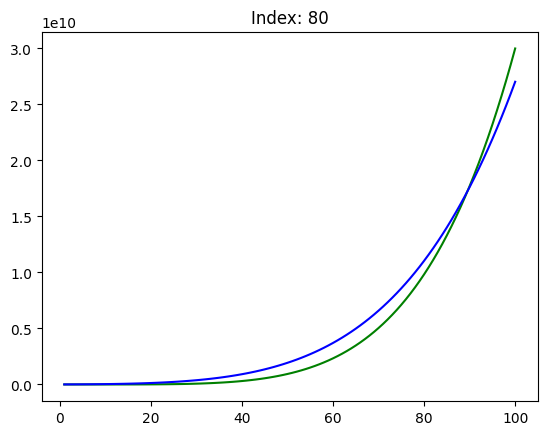

Target:   -3*x**5 + -2*x**4 + 2*x**3 + 2*x**2 + 1*x + +2
Best solution + * + ^ * 8.00 2.00 6.00 ^ * -7.00 + 3.00 + - 2.00 -3.00 9.00 -3.00 x / - * -8.00 8.00 x ^ + - -11.00 + x 1.00 -4.00 + -4.00 0.00
Best fitness -4.464188099413013e+19


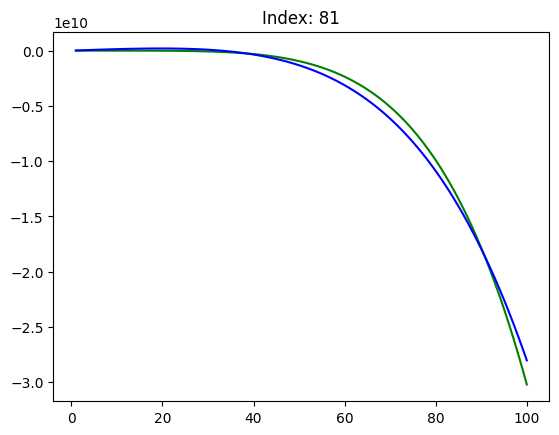

Target:   3*x**5 + 4*x**4 + 4*x**2 + -4*x + 5
Best solution ^ + * -5.00 + x ^ 4.00 -2.00 - x 5.00 4.00
Best fitness -1.0102382088769947e+20


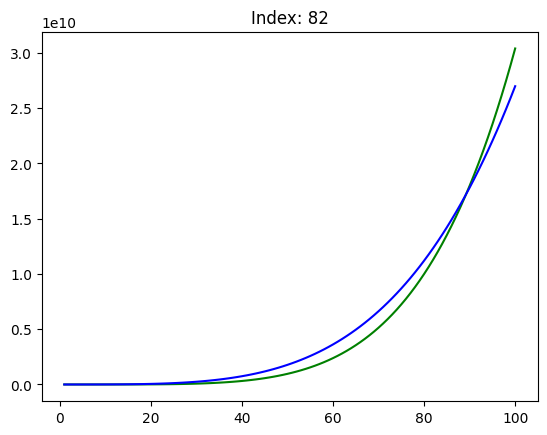

In [8]:
graph_predictions(best_models=best_models)